### Notebook for Angelo

my main problem - lack of computation power :(   

I got an error saying I used all the RAM available. I believe there will not be any errors. In case there are, please copy me the error message and I will fix it.   

In [1]:
import numpy as np
import pandas as pd
import umap

In [2]:



from transformers import T5Tokenizer, T5ForConditionalGeneration

#T5_cond_model = T5ForConditionalGeneration.from_pretrained('t5-base')
#T5_cond_model = T5ForConditionalGeneration.from_pretrained('t5-base')

model_path = '/home/angelo_ziletti/nlg-ra/T5_experiments/T5_plain/outputs_seed_2'

T5_cond_model = T5ForConditionalGeneration.from_pretrained(model_path)

#T5_cond_model = T5ForConditionalGeneration.from_pretrained('t5-base')

T5_tokenizer = T5Tokenizer.from_pretrained('t5-base')



In [3]:
### example

input_ids = T5_tokenizer('translate English to German: The house is wonderful.', return_tensors='pt').input_ids
labels = T5_tokenizer('Das Haus ist wunderbar.', return_tensors='pt').input_ids

# the forward function automatically creates the correct decoder_input_ids
# loss = T5_cond_model(input_ids=input_ids, labels=labels).loss

full_outputs = T5_cond_model(input_ids=input_ids, labels=labels, output_hidden_states=True, return_dict=True)

# outputs
full_outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

**loss** - language modeling loss    
**logits** - Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).    

**decoder_hidden_states** - Hidden-states of the decoder at the output of each layer plus the initial embedding outputs. (Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size))

**encoder_last_hidden_state** - Sequence of hidden-states at the output of the last layer of the encoder of the model.   

**encoder_hidden_states** - Hidden-states of the encoder at the output of each layer plus the initial embedding outputs. (Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).)



### So basically the procedure would be the following:   

- get the fine-tuned model for T5_plain (no conditioning)! - I am using just the pre-trained T5-base - CHANGE HERE
- get test_dataset samples
- for each test_sample get the decoder_hidden_states
- dimentionality reduction
- clustering -----> ideally should be 6 clear clusters   

### Now do the procedure for T5-base (pre-trained model, not fine-tuned)   

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import os.path


ROOT_FOLDER = "/home/angelo_ziletti/nlg-ra/T5_experiments"

MODEL = "T5_plain"
#PARTIAL_PATH_GENERATED = "hp_1e_3_1/test_generations_beam_1.txt"
#MODEL = "T5_condition"
#MODEL = "T5_condition_semantics"
#MODEL = "BART_base"
#MODEL = "BART_condition"
#MODEL = "BART_condition_semantics"

seed=1
#PARTIAL_PATH_GENERATED = "outputs_seed_{}/test_generations_beam_1.txt".format(seed)
PARTIAL_PATH_ORIGINAL = "input_data/test.target"
PARTIAL_PATH_TEST_SOURCES = "input_data/test.source"

PATH_TEST_SOURCES = os.path.abspath(os.path.normpath(os.path.join(ROOT_FOLDER, MODEL, PARTIAL_PATH_TEST_SOURCES)))
PATH_TEST_TARGET = os.path.abspath(os.path.normpath(os.path.join(ROOT_FOLDER, MODEL, PARTIAL_PATH_ORIGINAL)))

#PATH_GENERATED = os.path.abspath(os.path.normpath(os.path.join(ROOT_FOLDER, MODEL, PARTIAL_PATH_GENERATED)))
#PATH_ORIGINAL = os.path.abspath(os.path.normpath(os.path.join(ROOT_FOLDER, MODEL, PARTIAL_PATH_ORIGINAL)))

#print(PATH_GENERATED)
print(PATH_TEST_SOURCES)
print(PATH_TEST_TARGET)

/home/angelo_ziletti/nlg-ra/T5_experiments/T5_plain/input_data/test.source
/home/angelo_ziletti/nlg-ra/T5_experiments/T5_plain/input_data/test.target


In [4]:
# read test dataset
#PATH_TEST_TARGET = '/content/drive/MyDrive/bayer-intern/T5_plain_input/input_data/test.target'


#PATH_TEST_TARGET = 

with open(PATH_TEST_TARGET) as f:
    test_target_T5_plain = [line.strip() for line in f]


# read test dataset
#PATH_TEST_SOURCES = '/content/drive/MyDrive/bayer-intern/T5_plain_input/input_data/test.source'

with open(PATH_TEST_SOURCES) as f:
    test_sources_T5_plain = [line.strip() for line in f]
    
PATH_TEST_SOURCES_COND = '/home/angelo_ziletti/nlg-ra/T5_experiments/T5_condition/input_data/test.source'

with open(PATH_TEST_SOURCES_COND) as f:
    test_sources_T5_condition = [line.strip() for line in f]

In [5]:
assert len(test_target_T5_plain) == len(test_sources_T5_plain)

In [6]:
prefix = "summarize: "

In [7]:
### do just for one test sample

# test_sample = prefix + test_sources_T5_plain[0]
# label_sample = test_target_T5_plain[0]

# input_ids = T5_tokenizer(test_sample, return_tensors='pt').input_ids
# labels = T5_tokenizer(target, return_tensors='pt').input_ids

# full_outputs = T5_cond_model(input_ids=input_ids, labels=labels, output_hidden_states=True, return_dict=True)

In [8]:
len(test_sources_T5_plain)

742

In [93]:
#for sample_ind in range(len(test_sources_T5_plain)):
SAMPLES = len(test_sources_T5_plain)
#SAMPLES = 200

# store here the decoder hidden states of each test sample
decoder_hidden_states_per_test_sample = []
encoder_last_hidden_state_per_test_sample = []

for sample_ind in range(SAMPLES):
    print(sample_ind)
    # get the input and corresponding target
    input_source = test_sources_T5_plain[sample_ind]
    target = test_target_T5_plain[sample_ind]

    # add prefix (I believe by default HF was doing this for us in fine-tuning/inference, but I have to verify that)
    input_test_sample =  prefix + input_source
  
    input_ids_test_sample = T5_tokenizer(input_test_sample, return_tensors="pt").input_ids
    labels = T5_tokenizer(target, return_tensors='pt').input_ids

    full_outputs = T5_cond_model(input_ids=input_ids_test_sample, labels=labels, output_hidden_states=True, return_dict=True)

    #current_decoder_hidden_states = full_outputs['decoder_hidden_states'][0]

    current_decoder_hidden_states = np.average(full_outputs['decoder_hidden_states'][0].detach().cpu().numpy(), axis=1).reshape(-1)
    #print(current_decoder_hidden_states.shape)

    current_last_hidden_state = np.average(full_outputs['encoder_last_hidden_state'].detach().cpu().numpy(), axis=1).reshape(-1)
    #print(current_last_hidden_state.shape)

    print("Obtained decoder hidden states")
    
    decoder_hidden_states_per_test_sample.append(current_decoder_hidden_states)
    encoder_last_hidden_state_per_test_sample.append(current_last_hidden_state)

0


Token indices sequence length is longer than the specified maximum sequence length for this model (7452 > 512). Running this sequence through the model will result in indexing errors


Obtained decoder hidden states
1
Obtained decoder hidden states
2
Obtained decoder hidden states
3
Obtained decoder hidden states
4
Obtained decoder hidden states
5
Obtained decoder hidden states
6
Obtained decoder hidden states
7
Obtained decoder hidden states
8
Obtained decoder hidden states
9
Obtained decoder hidden states
10
Obtained decoder hidden states
11
Obtained decoder hidden states
12
Obtained decoder hidden states
13
Obtained decoder hidden states
14
Obtained decoder hidden states
15
Obtained decoder hidden states
16
Obtained decoder hidden states
17
Obtained decoder hidden states
18
Obtained decoder hidden states
19
Obtained decoder hidden states
20
Obtained decoder hidden states
21
Obtained decoder hidden states
22
Obtained decoder hidden states
23
Obtained decoder hidden states
24
Obtained decoder hidden states
25
Obtained decoder hidden states
26
Obtained decoder hidden states
27
Obtained decoder hidden states
28
Obtained decoder hidden states
29
Obtained decoder hidden

Obtained decoder hidden states
239
Obtained decoder hidden states
240
Obtained decoder hidden states
241
Obtained decoder hidden states
242
Obtained decoder hidden states
243
Obtained decoder hidden states
244
Obtained decoder hidden states
245
Obtained decoder hidden states
246
Obtained decoder hidden states
247
Obtained decoder hidden states
248
Obtained decoder hidden states
249
Obtained decoder hidden states
250
Obtained decoder hidden states
251
Obtained decoder hidden states
252
Obtained decoder hidden states
253
Obtained decoder hidden states
254
Obtained decoder hidden states
255
Obtained decoder hidden states
256
Obtained decoder hidden states
257
Obtained decoder hidden states
258
Obtained decoder hidden states
259
Obtained decoder hidden states
260
Obtained decoder hidden states
261
Obtained decoder hidden states
262
Obtained decoder hidden states
263
Obtained decoder hidden states
264
Obtained decoder hidden states
265
Obtained decoder hidden states
266
Obtained decoder hid

Obtained decoder hidden states
474
Obtained decoder hidden states
475
Obtained decoder hidden states
476
Obtained decoder hidden states
477
Obtained decoder hidden states
478
Obtained decoder hidden states
479
Obtained decoder hidden states
480
Obtained decoder hidden states
481
Obtained decoder hidden states
482
Obtained decoder hidden states
483
Obtained decoder hidden states
484
Obtained decoder hidden states
485
Obtained decoder hidden states
486
Obtained decoder hidden states
487
Obtained decoder hidden states
488
Obtained decoder hidden states
489
Obtained decoder hidden states
490
Obtained decoder hidden states
491
Obtained decoder hidden states
492
Obtained decoder hidden states
493
Obtained decoder hidden states
494
Obtained decoder hidden states
495
Obtained decoder hidden states
496
Obtained decoder hidden states
497
Obtained decoder hidden states
498
Obtained decoder hidden states
499
Obtained decoder hidden states
500
Obtained decoder hidden states
501
Obtained decoder hid

Obtained decoder hidden states
709
Obtained decoder hidden states
710
Obtained decoder hidden states
711
Obtained decoder hidden states
712
Obtained decoder hidden states
713
Obtained decoder hidden states
714
Obtained decoder hidden states
715
Obtained decoder hidden states
716
Obtained decoder hidden states
717
Obtained decoder hidden states
718
Obtained decoder hidden states
719
Obtained decoder hidden states
720
Obtained decoder hidden states
721
Obtained decoder hidden states
722
Obtained decoder hidden states
723
Obtained decoder hidden states
724
Obtained decoder hidden states
725
Obtained decoder hidden states
726
Obtained decoder hidden states
727
Obtained decoder hidden states
728
Obtained decoder hidden states
729
Obtained decoder hidden states
730
Obtained decoder hidden states
731
Obtained decoder hidden states
732
Obtained decoder hidden states
733
Obtained decoder hidden states
734
Obtained decoder hidden states
735
Obtained decoder hidden states
736
Obtained decoder hid

In [94]:
full_outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

## Your session crashed after using all available RAM   :(

In [95]:
decoder_hidden_states = np.asarray(decoder_hidden_states_per_test_sample)
decoder_hidden_states.shape

(742, 768)

In [96]:
encoder_hidden_states = np.asarray(encoder_last_hidden_state_per_test_sample)
encoder_hidden_states.shape

(742, 768)

In [97]:
#np.save("./decoder_hidden_state_seed_2.npy", decoder_hidden_states)
#np.save("./encoder_hidden_state_seed_2.npy", encoder_hidden_states)

In [10]:
decoder_hidden_states = np.load("./decoder_hidden_state_seed_2.npy")
#decoder_hidden_states = np.load("./decoder_hidden_state.npy")
decoder_hidden_states.shape

(742, 768)

In [36]:
encoder_hidden_states = np.load("./encoder_hidden_state_seed_2.npy")
#encoder_hidden_states = np.load("./encoder_hidden_state.npy")
encoder_hidden_states.shape

(742, 768)

In [37]:
import hdbscan

In [12]:
min_cluster_size = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=5, cluster_selection_method='leaf', prediction_data=True)

In [13]:
#clusterer.fit(decoder_hidden_states)
clusterer.fit(encoder_hidden_states)


HDBSCAN(cluster_selection_method='leaf', min_cluster_size=15, min_samples=5,
        prediction_data=True)

In [14]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_labels = np.argmax(soft_clusters, axis=1)
soft_labels

array([1, 2, 2, 3, 0, 1, 2, 2, 1, 3, 0, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 3,
       0, 1, 1, 2, 0, 3, 1, 1, 2, 1, 3, 0, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1,
       3, 0, 1, 2, 2, 2, 3, 1, 2, 2, 1, 3, 0, 1, 2, 2, 2, 3, 0, 1, 1, 2,
       3, 0, 1, 1, 2, 2, 3, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 3, 1, 1, 2, 2,
       3, 0, 1, 2, 2, 1, 3, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 3, 0, 1, 1,
       2, 1, 3, 0, 0, 2, 2, 2, 3, 0, 1, 1, 2, 1, 3, 1, 2, 1, 3, 1, 0, 2,
       2, 1, 0, 2, 1, 3, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2,
       3, 0, 1, 2, 2, 1, 3, 1, 1, 2, 1, 3, 0, 1, 1, 2, 2, 3, 0, 1, 2, 2,
       2, 3, 0, 1, 2, 2, 1, 3, 0, 1, 2, 2, 1, 3, 1, 1, 2, 2, 3, 0, 1, 0,
       2, 0, 3, 1, 1, 2, 1, 3, 1, 1, 2, 1, 3, 0, 1, 1, 2, 2, 3, 0, 1, 1,
       2, 2, 3, 0, 1, 2, 2, 1, 3, 1, 2, 2, 2, 3, 1, 1, 2, 1, 3, 0, 1, 2,
       2, 1, 3, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 3, 0, 1, 3, 2, 2, 3, 1, 1,
       2, 2, 3, 1, 1, 2, 2, 3, 1, 2, 2, 1, 3, 0, 1, 2, 2, 1, 3, 1, 1, 2,
       1, 3, 1, 1, 2, 1, 3, 1, 2, 2, 1, 3, 0, 1, 1,

In [15]:
labels = clusterer.labels_
pd.Series(labels).value_counts()

-1    491
 3    103
 1     91
 2     38
 0     19
dtype: int64

In [16]:
pd.Series(soft_labels).value_counts()

1    283
2    240
3    115
0    104
dtype: int64

### =========================================================

In [17]:
cluster_nb = 1
idxs = list(np.where(labels == cluster_nb)[0])

test_target_T5_plain_cluster = [test_target_T5_plain[i] for i in idxs]    
test_target_T5_plain_cluster

["what incivo contains the active substance is telaprevir . each tablet of incivo contains 375 mg of telaprevir . the other ingredients are : tablet core hypromellose acetate succinate , calcium hydrogen phosphate ( anhydrous ), microcrystalline cellulose , silica colloidal anhydrous , sodium lauryl sulphate , croscarmellose sodium , sodium stearyl fumarate tablet film - coat polyvinyl alcohol , macrogol , talc , titanium dioxide ( e171 ), iron oxide yellow ( e172 ) what incivo looks like and contents of the pack film - coated tablet . yellow caplet - shaped tablets of approximately 20 mm in length , marked with ' t375 ' on one side . incivo is available in packs containing one bottle or 4 bottles per carton . each bottle contains one pouch or two pouches to keep the tablets dry ( desiccant ). not all pack - sizes may be marketed .",
 "what zinbryta contains the active substance is daclizumab beta . each pre - filled syringe contains 150 mg of daclizumab beta in 1 ml solution for injec

In [18]:
test_sources_T5_condition

['section 1: <PRODUCT_NAME> incivo </PRODUCT_NAME> <PROBLEM> the_virus </PROBLEM> <DX_NAME> hepatitis_c_infection </DX_NAME> <PROBLEM> chronic_hepatitis_c_infection </PROBLEM> <AGE> 1865 </AGE> <GENERIC_NAME> peginterferon_alfa </GENERIC_NAME> <GENERIC_NAME> ribavirin </GENERIC_NAME> <GENERIC_NAME> telaprevir </GENERIC_NAME> <TREATMENT> medicines </TREATMENT> <TREATMENT_NAME> ns3-4a_protease_inhibitors </TREATMENT_NAME> <TREATMENT> the_ns3-4a_protease_inhibitor </TREATMENT> <DX_NAME> hepatitis_c_virus </DX_NAME> <GENERIC_NAME> peginterferon_alfa </GENERIC_NAME> <GENERIC_NAME> ribavirin </GENERIC_NAME> <TREATMENT> incivo </TREATMENT> <PROBLEM> chronic_hepatitis_c_infection </PROBLEM> <PROBLEM> chronic_hepatitis_c_infection </PROBLEM> <TIME_TO_TREATMENT_NAME> previously </TIME_TO_TREATMENT_NAME> <TREATMENT> an_interferon-based_regimen </TREATMENT>',
 "section 2: <PRODUCT_NAME> incivo </PRODUCT_NAME> <PROBLEM> allergic </PROBLEM> <GENERIC_NAME> telaprevir </GENERIC_NAME> <TREATMENT> this_

In [38]:
section_labels = [item[:9] for item in test_sources_T5_condition]

In [39]:
section_labels

['section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 3',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'section 4',
 'section 5',
 'section 6',
 'section 1',
 'section 2',
 'sect

In [40]:
mapper = umap.UMAP().fit(encoder_hidden_states)

In [41]:
import umap.plot

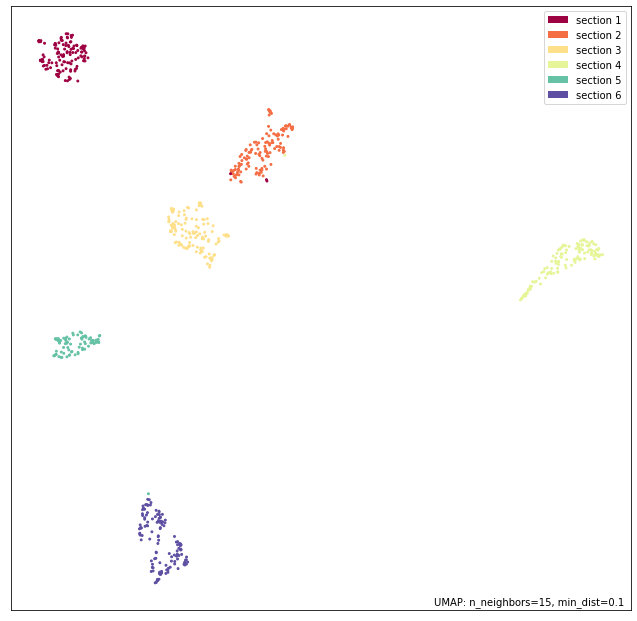

In [42]:
plot = umap.plot.points(mapper, labels=np.array(section_labels))

In [43]:
fig = plot.get_figure()
#fig.savefig("./section_embedding_t5_base.svg")
#fig.savefig("./section_embedding_t5_base.png")
fig.savefig("./section_embedding_t5_finetuned.svg")
fig.savefig("./section_embedding_t5_finetuned.png")

## My google Colab cells

In [13]:
!pip install datasets==1.6.0
!pip install transformers
!pip install rouge_score
!pip install sacrebleu
!pip install sentencepiece

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 21.8 MB 16.9 MB/s eta 0:00:01
ERROR: Could not find a version that satisfies the requirement numpy>=1.17 (from datasets==1.6.0) (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.3, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sacrebleu-1.3.7.tar.gz (26 kB)
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-7URcdu/sacrebleu/setup.py'"'"'; __file__='"'"'/tmp/pip-install-7URcdu/sacrebleu/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'

In [14]:
import datasets
import transformers
import pandas as pd
import numpy as np

#### Angelo:  

Do you think it would be easy for you to extract the hidden layer activations of T5 for the predictions for different sections?      

My idea would be that we extract the internal representations for each sections, and then perform hierarchical clustering and non-linear dimensionality reduction to  prove that the network already understands that it needs to generate different sections.     

Essentially, we should be able to detect different clusters depending on the section to be generated.    

I could do easily the clustering and non linear dimensionality reduction, but I would need from you to extract the internal representations from HF.    

Here is how to extract the hidden layers for the decoder and encoder:   
https://huggingface.co/transformers/main_classes/output.html#seq2seqlmoutput  

In [15]:
# from transformers import T5Tokenizer, T5Model

# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# model = T5Model.from_pretrained('t5-small')

# input_ids = tokenizer("Studies have been shown that owning a dog is good for you", return_tensors="pt").input_ids  # Batch size 1
# decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1
# outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

# last_hidden_states = outputs.last_hidden_state

In [16]:
from transformers import T5Tokenizer, T5Model

T5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
T5_model = T5Model.from_pretrained('t5-base')

In [17]:
# Example

input_ids = T5_tokenizer("Studies have been shown that owning a dog is good for you", return_tensors="pt").input_ids
decoder_input_ids = T5_tokenizer("Studies show that", return_tensors="pt").input_ids

outputs = T5_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, output_hidden_states=True)

In [18]:
outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

In [19]:
example_last_hidden_states = outputs.last_hidden_state

In [20]:
example_last_hidden_states

tensor([[[ 0.0005, -0.1320,  0.2328,  ...,  0.0699,  0.0568, -0.1638],
         [-0.0052, -0.1856,  0.1215,  ..., -0.0225, -0.0012, -0.2632],
         [ 0.0824, -0.3187,  0.0708,  ...,  0.0134,  0.0274, -0.3392],
         [ 0.1529, -0.4006,  0.1589,  ...,  0.0711,  0.0720, -0.2287]]],
       grad_fn=<MulBackward0>)

In [21]:
outputs.decoder_hidden_states

(tensor([[[ 18.2500,   9.8750,   1.1250,  ...,  11.9375,  -8.0625,  23.2500],
          [ -6.6250,   5.9688,   6.7500,  ...,  22.2500,  24.2500,  -7.8438],
          [  5.4375,  -3.4531,   6.9375,  ..., -17.1250, -14.7500,  -4.3438],
          [ 11.3750,  -4.8750,   9.0625,  ...,   4.8438,  14.3750,  -5.7812]]],
        grad_fn=<EmbeddingBackward>),
 tensor([[[ -5.5996, -98.1110,   4.0866,  ..., -20.7424,  13.2344,  34.8016],
          [-62.9431,   4.1005,  14.8842,  ...,   5.0339,  22.7906,   9.6113],
          [-39.0382,  18.5031, -48.3598,  ..., -51.9697, -34.3096,   2.9877],
          [-15.9806, -38.7855,  44.3457,  ...,  -9.7924,  14.4667,  15.1745]]],
        grad_fn=<AddBackward0>),
 tensor([[[ -20.4823, -228.2366,  -21.1243,  ...,   -2.6437,   18.3553,
             97.2003],
          [-115.1337, -136.2689,  -66.1991,  ...,   15.3909,   31.0594,
             61.1270],
          [ -80.9503,   -5.9507, -137.1890,  ...,  -41.4114,  -42.6181,
             27.8363],
          [ -11.

=============================================================================

https://huggingface.co/transformers/model_doc/t5.html#training   


**Supervised training**

In this setup the input sequence and output sequence are standard sequence-to-sequence input output mapping. In translation, for instance with the input sequence “The house is wonderful.” and output sequence “Das Haus ist wunderbar.”, the sentences should be processed as follows.    

The input sequence is fed to the model using **input_ids**. The *target sequence* is shifted to the right, i.e., prepended by a start-sequence token and *fed to the decoder using the decoder_input_ids*. 

In teacher-forcing style, the *target sequence* is then appended by the *EOS token and corresponds to the labels*. The PAD token is hereby used as the start-sequence token.

**T5ForConditionalGeneration** ~ T5 Model with a language modeling head on top.

In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

T5_cond_model = T5ForConditionalGeneration.from_pretrained('t5-base')
T5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [23]:
### example

input_ids = T5_tokenizer('translate English to German: The house is wonderful.', return_tensors='pt').input_ids
labels = T5_tokenizer('Das Haus ist wunderbar.', return_tensors='pt').input_ids

# the forward function automatically creates the correct decoder_input_ids
# loss = T5_cond_model(input_ids=input_ids, labels=labels).loss

full_outputs = T5_cond_model(input_ids=input_ids, labels=labels, output_hidden_states=True, return_dict=True)

In [24]:
full_outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

**loss** - language modeling loss    
**logits** - Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).    

**decoder_hidden_states** - Hidden-states of the decoder at the output of each layer plus the initial embedding outputs. (Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size))

**encoder_last_hidden_state** - Sequence of hidden-states at the output of the last layer of the encoder of the model.   

**encoder_hidden_states** - Hidden-states of the encoder at the output of each layer plus the initial embedding outputs. (Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).)



### So basically the procedure would be the following:   

- get the fine-tuned model    
- get test_dataset samples (split to batches)
- for each test_sample get the decoder_hidden_states
- dimentionality reduction
- clustering -----> ideally should be 6 clear clusters   

### Now do the procedure for T5-base (pre-trained model, not fine-tuned)   

In [25]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained('t5-small')
# model = T5ForConditionalGeneration.from_pretrained('t5-small')

# input_ids = tokenizer('The <extra_id_0> walks in <extra_id_1> park', return_tensors='pt').input_ids
# labels = tokenizer('<extra_id_0> cute dog <extra_id_1> the <extra_id_2> </s>', return_tensors='pt').input_ids
# outputs = model(input_ids=input_ids, labels=labels)
# loss = outputs.loss
# logits = outputs.logits

# input_ids = tokenizer("summarize: studies have shown that owning a dog is good for you ", return_tensors="pt").input_ids  # Batch size 1
# outputs = model.generate(input_ids)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# read test dataset
PATH_TEST_TARGET = '/content/drive/MyDrive/bayer-intern/T5_plain_input/input_data/test.target'

with open(PATH_TEST_TARGET) as f:
    test_target_T5_plain = [line.strip() for line in f]


# read test dataset
PATH_TEST_SOURCES = '/content/drive/MyDrive/bayer-intern/T5_plain_input/input_data/test.source'

with open(PATH_TEST_SOURCES) as f:
    test_sources_T5_plain = [line.strip() for line in f]

In [ ]:
assert len(test_target_T5_plain) == len(test_sources_T5_plain)

In [ ]:
decoder_hidden_states_per_test_sample = []

In [ ]:
prefix =  "summarize: "

In [ ]:
# test_sample = prefix + test_sources_T5_plain[0]
# label_sample = test_target_T5_plain[0]


# input_ids = T5_tokenizer(test_sample, return_tensors='pt').input_ids
# labels = T5_tokenizer(target, return_tensors='pt').input_ids

# full_outputs = T5_cond_model(input_ids=input_ids, labels=labels, output_hidden_states=True, return_dict=True)

In [ ]:
for sample_ind in range(len(test_sources_T5_plain)):

  input_source = test_sources_T5_plain[sample_ind]
  target = test_target_T5_plain[sample_ind]

  # add prefix (I believe by default HF was doing this for us, but I have to verify that)
  input_test_sample =  prefix + input_source

  input_ids_test_sample = T5_tokenizer(input_test_sample, return_tensors="pt").input_ids
  labels = T5_tokenizer(target, return_tensors='pt').input_ids

  full_outputs = T5_cond_model(input_ids=input_ids_test_sample, labels=labels, output_hidden_states=True, return_dict=True)

  current_decoder_hidden_states = full_outputs['decoder_hidden_states']

  decoder_hidden_states_per_test_sample.append(current_decoder_hidden_states)

In [ ]:
# Your session crashed after using all available RAM.